# Wildcard Handling with Astroquery.mast

----

## Learning Goals

By the end of this tutorial, you will:

* Use the wildcards available for `astroquery.mast.Observations` criteria queries
* Broaden and refine `astroquery.mast.Observations` criteria queries
* Fully utilize the `instrument_name` criteria, especially for JWST queries
* Query for moving targets using target ephemeris and time criteria such as `t_min` and `t_max`

## Introduction

This Notebook demonstrates the use of wildcards in `astroquery.mast.Observations` criteria queries. The use of wildcards is encouraged for certain criteria types (namely, `string` object types) to ensure your query returns all results. 

We will demonstrate 3 use-cases for wildcards when doing criteria queries and emphasize certain criteria where wildcard usage is highly encouraged, particularly for JWST queries. We will also use the last example to demonstrate the use of value ranges when working with `float` object criteria types.

The workflow for this notebook consists of:

* [Wildcard overview with `astroquery.mast.Observations`](#overview)
    1. [Wildcard Search with `instrument_name`](#case1)
    2. [Wildcard Search with `instrument_name` and `proposal_id`](#case2)
    3. [Wildcard Search a Time-sensitive Object with `target_name` and `t_min`](#case3)
* Resources

## Imports

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import Table, unique, vstack
from astropy.time import Time
from astroquery.mast import Observations

----

<a id="overview"></a>
## Wildcards with `astroquery.mast.Observations`

The use of wildcards when making `astroquery.mast.Observations` queries can help ensure you retrieve all observations without leaving anything out. The available wildcards are `%` and `*`: `%` replaces a single character, while `*` replaces more than one character preceding, following, or in between the existing characters, depending on its placement. See the [Observation Criteria Queries](https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries) section in the `astroquery.mast` documentation for more information on the wildcards.

Wildcards are only available for certain criteria. `string` type objects accept wildcards, but `float`, `integer`, or any other objects do not accept wildcards.

Users may call the `get_metadata` method to see the list of query criteria and their data types. The criteria listed as `string` objects under the **Data Type** column are criteria that can be called with wildcards:

In [2]:
Observations.get_metadata("observations")

Column Name,Column Label,Data Type,Units,Description,Examples/Valid Values
str21,str25,str7,str10,str72,str116
intentType,Observation Type,string,,Whether observation is for science or calibration.,"Valid values: science, calibration"
obs_collection,Mission,string,,Collection,"E.g. SWIFT, PS1, HST, IUE"
provenance_name,Provenance Name,string,,"Provenance name, or source of data","E.g. TASOC, CALSTIS, PS1"
instrument_name,Instrument,string,,Instrument Name,"E.g. WFPC2/WFC, UVOT, STIS/CCD"
project,Project,string,,Processing project,"E.g. HST, HLA, EUVE, hlsp_legus"
filters,Filters,string,,Instrument filters,"F469N, NUV, FUV, LOW DISP, MIRROR"
wavelength_region,Waveband,string,,Energy Band,"EUV, XRAY, OPTICAL"
target_name,Target Name,string,,Target Name,Ex. COMET-67P-CHURYUMOV-GER-UPDATE
target_classification,Target Classification,string,,Type of target,Ex. COMET;COMET BEING ORBITED BY THE ROSETTA SPACECRAFT;SOLAR SYSTEM


<a id="case1"></a>
### Case 1: Wildcard Search with `instrument_name`

For our first example we will search for all NIRISS observations taken by a certain proposal/program PI. Our two query criteria are `proposal_pi` and `instrument_name`, which are both `string` object criteria. As such, both can be wildcarded for ease of use. 

In fact, it is sometimes necessary to use wildcards when searching on `instrument_name`. Both HST and JWST use instrument configurations in this field to allow for more precise advanced searches (e.g. NIRISS/IMAGE and STIS/FUV-MAMA). When performing a "generic" search, you must include a wildcard or these more detailed results will be excluded.

We will demonstrate this by looking at the results for the query below:

In [3]:
observations = Observations.query_criteria(proposal_pi="Espinoza, Nestor",
                                           instrument_name="NIRISS*")
observations

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str12,str4,str13,str8,str14,str54,str50,float64,float64,str10,str16,int64,float64,float64,float64,float64,float64,str70,float64,str4,str3,int64,str132,str80,str81,str16,bool,float64,str9,str9
science,JWST,CALJWST,NIRISS/IMAGE,JWST,CLEAR;GR700XD,INFRARED,ECLIPTIC-RA80,Calibration; External flat field,jw01541005001_0210h_00001_nis,124.10089166666668,19.23126111111111,image,"Espinoza, Nestor",2,59688.661724637386,59688.665328414354,300.63,600.0,2800.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 124.079361272 19.219997306 124.088204918 19.256195264 124.126749247 19.247627141 124.117926871 19.211434025,mast:JWST/product/jw01541005001_0210h_00001_nis_trapsfilled.jpg,mast:JWST/product/jw01541005001_0210h_00001_nis_rateints.fits,PUBLIC,False,nan,79661376,733199805
science,JWST,CALJWST,NIRISS/IMAGE,JWST,CLEAR;GR700XD,INFRARED,ECLIPTIC-RA80,Calibration; External flat field,jw01541005001_0210v_00001_nis,124.10089166666668,19.23126111111111,image,"Espinoza, Nestor",2,59688.69811052859,59688.70171430556,300.63,600.0,2800.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 124.070680154 19.221940542 124.079522008 19.258138913 124.118067242 19.249572589 124.109246657 19.213379062,mast:JWST/product/jw01541005001_0210v_00001_nis_trapsfilled.jpg,mast:JWST/product/jw01541005001_0210v_00001_nis_rateints.fits,PUBLIC,False,nan,79661402,733199880
science,JWST,CALJWST,NIRISS/IMAGE,JWST,CLEAR;GR700XD,INFRARED,ECLIPTIC-RA80,Calibration; External flat field,jw01541005001_0210b_00001_nis,124.10089166666668,19.23126111111111,image,"Espinoza, Nestor",2,59688.646151315625,59688.64975509259,300.63,600.0,2800.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 124.080801154 19.213559815 124.089644763 19.249757705 124.128187507 19.241189289 124.119365169 19.20499624,mast:JWST/product/jw01541005001_0210b_00001_nis_trapsfilled.jpg,mast:JWST/product/jw01541005001_0210b_00001_nis_rateints.fits,PUBLIC,False,nan,79661433,733199936
science,JWST,CALJWST,NIRISS/IMAGE,JWST,CLEAR;GR700XD,INFRARED,ECLIPTIC-RA80,Calibration; External flat field,jw01541005001_0210p_00001_nis,124.10089166666668,19.23126111111111,image,"Espinoza, Nestor",2,59688.682512021645,59688.68611579861,300.63,600.0,2800.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 124.072120417 19.215503156 124.080962242 19.251701457 124.119505889 19.243134834 124.110685335 19.206941375,mast:JWST/product/jw01541005001_0210p_00001_nis_trapsfilled.jpg,mast:JWST/product/jw01541005001_0210p_00001_nis_rateints.fits,PUBLIC,False,nan,79661458,733199999
science,JWST,CALJWST,NIRISS/IMAGE,JWST,CLEAR;GR700XD,INFRARED,ECLIPTIC-RA80,Calibration; External flat field,jw01541005001_0210n_00001_nis,124.10089166666668,19.23126111111111,image,"Espinoza, Nestor",2,59688.677321651274,59688.68092542824,300.63,600.0,2800.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 124.075014085 19.214855403 124.083856539 19.25105356 124.122399877 19.242486306 124.113578694 19.206292991,mast:JWST/product/jw01541005001_0210n_00001_nis_trapsfilled.jpg,mast:JWST/product/jw01541005001_0210n_00001_nis_rateints.fits,PUBLIC,False,nan,79661490,733200051
science,JWST,CALJWST,NIRISS/IMAGE,JWST,CLEAR;GR700XD,INFRARED,ECLIPTIC-RA80,Calibration; External flat field,jw01541005001_0210t_00001_nis,124.10089166666668,19.23126111111111,image,"Espinoza, Nestor",2,59688.69290682489,59688.696510601854,300.63,600.0,2800.0,NIRISS Sens

Our query returned many NIRISS observations led by the PI Dr. Espinoza. Let's get all the unique values under the `instrument_name` column to see what our `*` wildcard picked up.

In [4]:
set(observations['instrument_name'])

{np.str_('NIRISS/IMAGE'), np.str_('NIRISS/SOSS')}

Our observations have the advanced labeling; had we simply set `instrument_name = "NIRISS"`, we would have missed several observations. For more details on this advanced labeling, see the [JWST Instrument Names page](https://outerspace.stsci.edu/display/MASTDOCS/JWST+Instrument+Names).

#### A note of caution: There is such a thing as too many wildcards

You can be too generous with the wildcards, so be sure to exercise caution in their use. Too much ambiguity can lead to unintended results. Let's take a look at our example below.

In [5]:
observations = Observations.query_criteria(proposal_pi='Espinoza, Nestor',
                                           instrument_name='NIR*') # Surely only one instrument begins with 'NIR'
set(observations['instrument_name'])

{np.str_('NIRISS/IMAGE'), np.str_('NIRISS/SOSS'), np.str_('NIRSPEC/SLIT')}

This query returns `NIRSPEC/SLIT` observations in addition to the NIRISS ones, which is not what we intended.

<a id="case2"></a>
### Case 2: Wildcard Search with `instrument_name` and `proposal_id`

Let's add an additional `string` criterion and wildcard into the mix. We'll do this with the `proposal_id` field which, despite its numeric content, is encoded as a string.

Let's query for a four digit proposal/program IDs that begin with `15`.

In [6]:
observations = Observations.query_criteria(proposal_pi='Espinoza, Nestor',
                                           instrument_name='NIRISS*',
                                           proposal_id=['15%%']) # Only a four digit result will match this

set(observations['proposal_id']), set(observations['instrument_name'])

({np.str_('1512'), np.str_('1541')},
 {np.str_('NIRISS/IMAGE'), np.str_('NIRISS/SOSS')})

<a id="case3"></a>
### Case 3: Create a Moving Target Ephemeris using MAST Observations with Wildcard Search

We will be querying for image observations of Comet 67P Churyumov-Gerasimenko observed through the Hubble Space Telescope's Advanced Camera for Surveys (ACS) Wide Field Camera (WFC). This comet's name can be listed in different ways, so we will use `*` wildcards in our criteria query.

In [7]:
observations = Observations.query_criteria(target_name="*67P*",
                                           instrument_name="ACS/WFC")

print(f"{len(observations)} total observations" + "\n")
print("Listed target names:")
print(set(observations['target_name']))

140 total observations

Listed target names:
{np.str_('COMET-67P-CHURYUMOV-GERASIMENK'), np.str_('COMET-67P-CHURYUMOV-GER-UPDATE')}


Above there are two names we get for Comet-67P. You should exercise caution when searching on the `target_name` criteria, since this is often entered by the PI who proposed the observation and can vary from person to person.

In the remainder of this notebook, we will construct a bare-bones ephemeris using the filtered MAST observations of this object and their metadata. We will then do some reverse engineering to query for the target based on coordinates using the ephemeris table, and hope that we get the same results back! Let's begin:

For simplicity, let's work only with the `'COMET-67P-CHURYUMOV-GERASIMENK'` observations to create our ephemeris.

In [8]:
mask = observations["target_name"] == "COMET-67P-CHURYUMOV-GERASIMENK"
filtered_observations = observations[mask]
filtered_observations

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str3,str6,str7,str3,str12,str7,str30,str89,str36,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str119,float64,str5,str3,int64,str2243,str86,str35,str6,bool,float64,str8,str9
science,HST,CALACS,ACS/WFC,HST,F606W,OPTICAL,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET-67P-CHURYUMOV-GERASIMENKO WHICH IS THE PRIMARY TARGET FOR ROSETTA SPACECRAFT,jcis02010,281.1070302812,-31.0066887554,image,"Hines, Dean C.",3,56888.26101200232,56888.48685717593,9600.0,470.0,720.0,Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Supporting the Rosetta Mission,57253.60605318,13863,GO,--,POLYGON -78.905924930000026 -31.02423579 -78.87427893 -31.0173634 -78.8800066 -30.98912327 -78.882365737150309 -30.989635932676503 -78.882504439999991 -30.98895186 -78.889317083503954 -30.990432181918216 -78.889530770000022 -30.98937778 -78.891752852813568 -30.989860489154527 -78.891883689999986 -30.98921489 -78.899628421871924 -30.990897116662392 -78.9001551 -30.98829685 -78.902371489060187 -30.988778129799261 -78.90250218 -30.98813288 -78.909141342406116 -30.989574421562239 -78.909719680000023 -30.98671762 -78.911930371781551 -30.987197501880228 -78.91206093 -30.98655257 -78.943699260000017 -30.99341636 -78.937989440000024 -31.02165911 -78.935778550730731 -31.021179788693974 -78.935648239999978 -31.02182416 -78.929005954826081 -31.020383985804244 -78.928427829999976 -31.02324132 -78.926211233460563 -31.02276060029919 -78.926080790000015 -31.02340529 -78.918332079103052 -31.0217246209393 -78.91780553000001 -31.02432554 -78.9155832393156 -31.023843392393292 -78.91545265000002 -31.02448843 -78.9086363989854 -31.023009444135333 -78.908422719999976 -31.02406438 -78.906063370071536 -31.023552312315246 -78.905924930000026 -31.02423579 -78.905924930000026 -31.02423579,mast:HST/product/jcis02010_drz.jpg,mast:HST/product/jcis02010_drz.fits,PUBLIC,True,nan,24839229,743573585
science,HST,CALACS,ACS/WFC,HST,F606W,OPTICAL,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET-67P-CHURYUMOV-GERASIMENKO WHICH IS THE PRIMARY TARGET FOR ROSETTA SPACECRAFT,jcis04020,290.2770693515,-28.02111499969,image,"Hines, Dean C.",3,56977.45820188658,56977.611049039355,6280.0,470.0,720.0,Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Supporting the Rosetta Mission,57342.94112256,13863,GO,--,POLYGON -69.68999134 -28.03180292 -69.690000793261078 -28.0314964187349 -69.68653658 -28.03117872 -69.686564584120333 -28.03027073277142 -69.683764119999978 -28.03001384 -69.6838006065022 -28.028831798853574 -69.67044575 -28.02760593 -69.670481996731183 -28.026436279688706 -69.666591489999973 -28.02607881 -69.666601003399478 -28.025772506303237 -69.663133870000024 -28.02545393 -69.664023900000018 -27.99678969 -69.695551850000015 -27.99968392 -69.695542411269713 -27.999990871866526 -69.69900966 -28.0003088 -69.6989737114984 -28.001477839264155 -69.702862620000019 -28.00183422 -69.702826356326327 -28.00301616323647 -69.716178669999977 -28.00423892 -69.716150921131742 -28.005146940581007 -69.718950740000025 -28.00540317 -69.718941361850952 -28.005710310378014 -69.722405690000016 -28.00602736 -69.722395728297926 -28.006353608328851 -69.735389909999981 -28.00754168 -69.7353798073961 -28.007874214140372 -69.739126740000017 -28.00821667 -69.73825566 -28.03688132 -69.70671568 -28.03399601 -69.706725863943035 -28.033664169692418 -69.70297905000001 -28.03332102 -69.702989071877354 -28.032994456845575 -69.68999134 -28.03180292 -69.68999134 -28.03180292,mast:HST/product/jcis04020_drz.jpg,mast:HST/product/jcis04020_drz.fits,PUBLIC,True,nan,24839232,741030402
science,HST,CALACS,ACS/WFC,HST,F775W,OPTICAL,COMET-67P-CHURYUMOV-GERASIMENK,

Now that we have our filtered observations, let's sort the rows of this table based on the `t_min` criteria, which refers to the start time of the exposure in MJD.

In [9]:
filtered_observations.sort("t_min")

Now that we've sorted our table, let's construct a basic ephemeris showing the path of our object over time (with `t_min`, or exposure start in MJD, as our time component):

In [10]:
ephemeris = Table([filtered_observations["s_ra"],
                   filtered_observations["s_dec"],
                   filtered_observations["t_min"]], names=("ra", "dec", "t_min"))

Let's display the contents of our ephemeris, and use it to generate a plot of the comet's path:

In [11]:
ephemeris.sort("t_min")
ephemeris

ra,dec,t_min
float64,float64,float64
281.2558788729,-31.01619293249,56887.26573422454
281.1070408364967,-31.006679797131913,56888.26101
281.1070302812,-31.0066887554,56888.26101200232
281.1045408863173,-31.00650879708346,56888.27707
281.0975108367455,-31.006933797314236,56888.32419
281.0951608865579,-31.006770747268593,56888.34025
281.0868808868347,-31.005851797486205,56888.39054
281.0845408866453,-31.005687797434355,56888.40661
281.0773208868312,-31.004271747618215,56888.4569


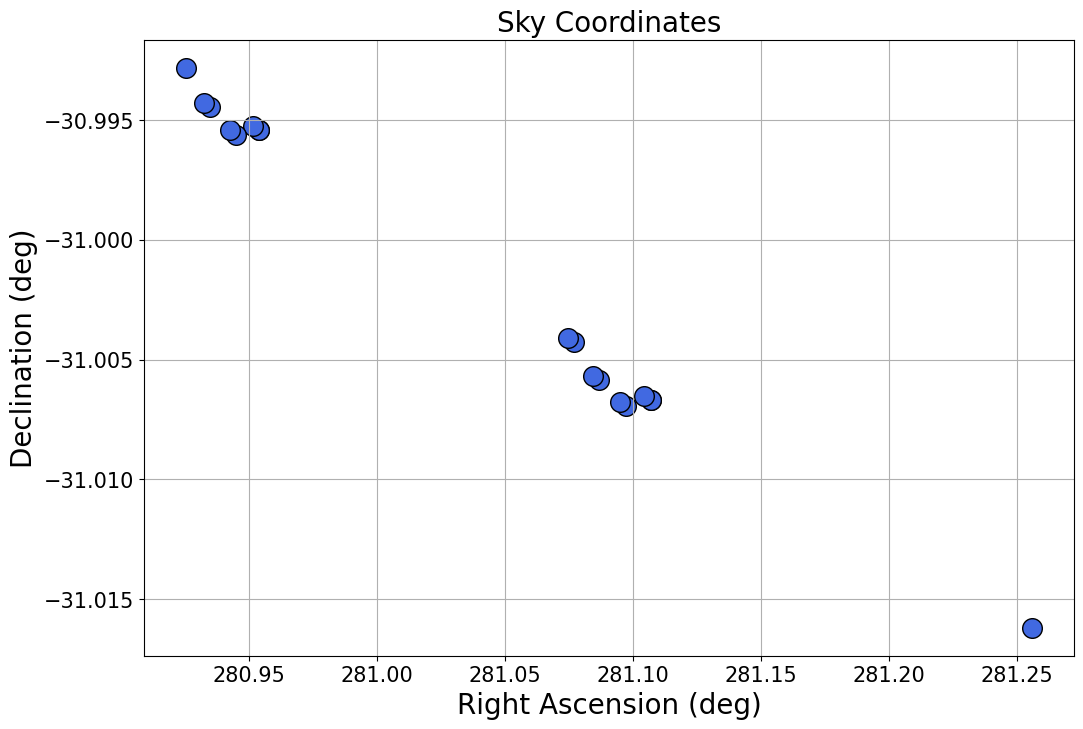

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(ephemeris[0:18]['ra'], ephemeris[0:18]['dec'], color='royalblue', s=200, lw=1., edgecolor='k')

plt.xlabel("Right Ascension (deg)", fontsize=20)
plt.ylabel("Declination (deg)", fontsize=20)

plt.title("Sky Coordinates", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

You can choose to save the ephemeris table in your current working directory by running the cell below:

In [13]:
# Overwriting is not necessary, but prevents this Notebook from failing STScI's automated testing
ephemeris.write('ephemeris-comet67p-cg.csv', format='ascii', overwrite=True)

## Resources

The following is a list of resources that were referenced throughout the tutorial, as well as some additional references that you may find useful:

* [`astroquery.mast.Observation` criteria queries](https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries)
* [JWST Instrument Names](https://outerspace.stsci.edu/display/MASTDOCS/JWST+Instrument+Names)

## Citations

If you use any of astroquery's tools for published research, please cite the authors. Follow this link for more information about citing astroquery:

* [Citing astroquery](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)

## About This Notebook

If you have comments or questions on this notebook, please contact us through the Archive Help Desk e-mail at archive@stsci.edu. <br>
<br>
Author: Jenny V. Medina <br>
Keywords: astroquery, wildcards, moving target <br>
Last Updated: Jun 2023